In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

The purpose of this notebook is to create generalized/customizable functions that can be used for Large Scale Food Fortification multiplication models with dichotomous outcomes (zinc, vitamin A, folic acid). The outcomes (DALYs averted) generated by this notebook assume the following:

- Complete scale-up achieved between starting baseline and alternative scenario coverage (med/high/low levels), defined according to the proportion of the population that eats industrially produced vehicles. This notebook does NOT currently consider the additional coverage over time in the alternative scenario defined according to the proportion of the population that eats the vehicle at all (due to campaign to convince additional individuals to eat fortified versions of vehicle).
- All individuals covered by fortification are assumed to be *effectively* covered. This assumption is not valid based on age- and timing-effects built into the full-scale models. These nutrient-specific effects should be added into the respective mutliplication model for the full results

In [2]:
location_ids = [163, 214, 205, 190, 189]

"""Note: full set of location IDs is shown below, but subset used here
was selected because they are the locations with non-missing coverage data
for the nutrient and vehicle of interest (vitamin A/oil)

[168, 161, 201, 202, 6, 205, 171, 141, 179, 207, 163, 11, 180, 181,
184, 15, 164, 213, 214, 165, 196, 522, 190, 189, 20]"""

ages = [2,3,4,5]
sexes = [1,2]

index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.25, 0.5, 0.75]

In [3]:
coverage_scale_up_proportion = 0.75
subsequent_scale_up_rate = 0

In [4]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
cause_ids = [389, 302, 341]
nonfatal_causes = [389]
nutrient = 'vitamin a'
vehicle = 'oil'

In [5]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [6]:
def generate_rr_deficiency_nofort_draws(mean, std):
    """This function takes a distribution for the relative risk
    for lack of fortification of a particular nutrient and generates
    1,000 draws based on that distribution. The data is the duplicated
    so that it is the same for each location ID so that it can be easily
    used later in the calculations."""
    data = pd.DataFrame()    
    np.random.seed(7)
    data['rr'] = np.random.lognormal(mean, std, size=1000)
    draws = []
    for i in list(range(0,1000)):
        draws.append(f'draw_{i}')
    data['draws'] = draws
    data = pd.DataFrame.pivot_table(data, values='rr', columns='draws').reset_index().drop(columns=['index'])
    df = pd.DataFrame(np.repeat(data.values,len(location_ids),axis=0))
    df.columns = data.columns
    df['location_id'] = location_ids
    df = df.set_index('location_id')
    return df

In [7]:
def pull_cause_specific_dalys_deficiency_pafs(rei_id, cause_ids):
    """This function pulls PAF data from GBD for specified 
    risk outcome pairs. Note that the risk in this context 
    will/should be nutrient *deficiencies*, not the lack of 
    nutrient fortification"""
    
    data = pd.DataFrame()
    for cause_id in cause_ids:
        temp = get_draws(
            gbd_id_type=['rei_id', 'cause_id'], 
            gbd_id=[rei_id, cause_id],
            source='burdenator',
            measure_id=2, #dalys
            metric_id=2, #percent
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes, 
            gbd_round_id=6,
            status='best',
            decomp_step='step5',
        )
        data = pd.concat([data,temp], ignore_index=True)
    data = data.set_index(index_cols + ['cause_id'])
    data = data.drop(columns=[c for c in data.columns if 'draw' not in c]).sort_index()
    return data

In [8]:
def pull_dalys(cause_ids):
    """This function pulls dalys for specified cause IDs from GBD"""
    
    ylds = get_draws(
        gbd_id_type='cause_id', 
        gbd_id=cause_ids,
        source='como',
        measure_id=3,
        metric_id=3, # only available as rate
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes, 
        gbd_round_id=6,
        status='best',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id'])
    ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])
    pop = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4').set_index(index_cols)
    for i in list(range(0,1000)):
        ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    ylls = get_draws(
        gbd_id_type='cause_id', 
        gbd_id=cause_ids,
        source='codcorrect',
        measure_id=4,
        metric_id=1, 
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes, 
        gbd_round_id=6,
        status='latest',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
    ylls= ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])
    for nf in nonfatal_causes:
        nonfatal = ylls.groupby(index_cols).sum()
        nonfatal['cause_id'] = nf
        for i in list(range(0,1000)):
            nonfatal[f'draw_{i}'] = 0
    ylls = pd.concat([ylls.reset_index(), nonfatal.reset_index()]).set_index(index_cols + ['cause_id'])
    
    dalys = ylls + ylds
    return dalys

In [100]:
def generate_alternative_coverage_algorithm(nutrient, vehicle, percent_of_2021_possible_jump, subsequent_scale_up_rate):
    data = pd.read_csv('/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
    data['value_mean'] = data['value_mean'].replace(100,100 - 0.00001 * 2)
    data['value_025_percentile'] = data['value_025_percentile'].replace(100,100 - 0.00001 * 3)
    data['value_975_percentile'] = data['value_975_percentile'].replace(100,100 - 0.00001)
   
    data = data.loc[data.vehicle == vehicle].loc[data.nutrient.isin([nutrient, 'na'])]
    data['value_std'] = (data.value_975_percentile - data.value_025_percentile) / 2 / 1.96
    data['a'] = (data.value_025_percentile - data.value_mean) / data.value_std
    data['b'] = (data.value_975_percentile - data.value_mean) / data.value_std       
          
    cov_a = data.loc[data.value_description == 'percent of population eating fortified vehicle'].drop(columns='value_description')
    for i in list(range(0,1000)):
        np.random.seed(11)
        cov_a[f'draw_{i}'] = scipy.stats.truncnorm.rvs(cov_a.a, cov_a.b, cov_a.value_mean, cov_a.value_std) / 100
    cov_a = cov_a.set_index(['location_id']).drop(columns=[c for c in cov_a.columns if 'draw' not in c and c not in ['location_id','value_description']])
    
    cov_b = data.loc[data.value_description == 'percent of population eating industrially produced vehicle'].drop(columns='value_description')
    for i in list(range(0,1000)):
        np.random.seed(11)
        cov_b[f'draw_{i}'] = scipy.stats.truncnorm.rvs(cov_b.a, cov_b.b, cov_b.value_mean, cov_b.value_std) / 100
    cov_b = cov_b.set_index(['location_id']).drop(columns=[c for c in cov_b.columns if 'draw' not in c and c not in ['location_id','value_description']])
    
    cov_c = data.loc[data.value_description == 'percent of population eating vehicle'].drop(columns='value_description')
    for i in list(range(0,1000)):
        np.random.seed(11)
        cov_c[f'draw_{i}'] = scipy.stats.truncnorm.rvs(cov_c.a, cov_c.b, cov_c.value_mean, cov_c.value_std) / 100
    cov_c = cov_c.set_index(['location_id']).drop(columns=[c for c in cov_c.columns if 'draw' not in c and c not in ['location_id','value_description']])
    
    assert np.all(cov_a <= cov_b)
    assert np.all(cov_b <= cov_c)
    
    cov_20 = cov_a.copy()
    cov_20['year'] = 2020
    cov_21 = (cov_b - cov_a) * percent_of_2021_possible_jump + cov_b
    cov_21['year'] = 2021
    if percent_of_2021_possible_jump == 1:
        cov_22 = cov_c - (cov_c - cov_b) * (1 - subsequent_scale_up_rate) ** (2)
        cov_22['year'] = 2022
        cov_23 = cov_c - (cov_c - cov_b) * (1 - subsequent_scale_up_rate) ** (3)
        cov_23['year'] = 2023
        cov_24 = cov_c - (cov_c - cov_b) * (1 - subsequent_scale_up_rate) ** (4)
        cov_24['year'] = 2024
    else: 
        cov_22 = (cov_b - cov_a) * percent_of_2021_possible_jump + cov_b
        cov_22['year'] = 2022
        cov_23 = (cov_b - cov_a) * percent_of_2021_possible_jump + cov_b
        cov_23['year'] = 2023
        cov_24 = (cov_b - cov_a) * percent_of_2021_possible_jump + cov_b
        cov_24['year'] = 2024
    data = pd.concat([cov_20,cov_21,cov_22,cov_23,cov_24]).reset_index().set_index(['location_id','year']).sort_index()
    
    return data

In [101]:
def generate_baseline_coverage_algorithm(nutrient, vehicle):
    data = pd.read_csv('/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
    data['value_mean'] = data['value_mean'].replace(100,100 - 0.00001 * 2)
    data['value_025_percentile'] = data['value_025_percentile'].replace(100,100 - 0.00001 * 3)
    data['value_975_percentile'] = data['value_975_percentile'].replace(100,100 - 0.00001)
   
    data = data.loc[data.vehicle == vehicle].loc[data.nutrient.isin([nutrient, 'na'])]
    data['value_std'] = (data.value_975_percentile - data.value_025_percentile) / 2 / 1.96
    data['a'] = (data.value_025_percentile - data.value_mean) / data.value_std
    data['b'] = (data.value_975_percentile - data.value_mean) / data.value_std       
          
    cov_a = data.loc[data.value_description == 'percent of population eating fortified vehicle'].drop(columns='value_description')
    for i in list(range(0,1000)):
        np.random.seed(11)
        cov_a[f'draw_{i}'] = scipy.stats.truncnorm.rvs(cov_a.a, cov_a.b, cov_a.value_mean, cov_a.value_std) / 100
    cov_a = cov_a.set_index(['location_id']).drop(columns=[c for c in cov_a.columns if 'draw' not in c and c not in ['location_id','value_description']])
    
    cov_20 = cov_a.copy()
    cov_20['year'] = 2020
    cov_21 = cov_a.copy()
    cov_21['year'] = 2021
    cov_22 = cov_a.copy()
    cov_22['year'] = 2022
    cov_23 = cov_a.copy()
    cov_23['year'] = 2023
    cov_24 = cov_a.copy()
    cov_24['year'] = 2024
    
    data = pd.concat([cov_20,cov_21,cov_22,cov_23,cov_24]).reset_index().set_index(['location_id','year']).sort_index()
    
    return data

In [102]:
baseline_coverage = generate_baseline_coverage_algorithm(nutrient, vehicle)
baseline_coverage.head()

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5  \
location_id year                                                               
163         2020  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2021  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2022  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2023  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2024  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   

                    draw_6    draw_7    draw_8    draw_9  ...  draw_990  \
location_id year                                          ...             
163         2020  0.228618  0.228618  0.228618  0.228618  ...  0.228618   
            2021  0.228618  0.228618  0.228618  0.228618  ...  0.228618   
            2022  0.228618  0.228618  0.228618  0.228618  ...  0.228618   
            2023  0.228618  0.228618  0.228618  0.228618  ...  0.228618   
            2024  0.228618  0.228618  0.228618  0.228618  ...  0.228618   

                  draw_991  draw_992  draw_993  draw_994  draw_995  draw_996  \
location_id year                                                               
163         2020  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2021  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2022  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2023  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2024  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   

                  draw_997  draw_998  draw_999  
location_id year                                
163         2020  0.228618  0.228618  0.228618  
            2021  0.228618  0.228618  0.228618  
            2022  0.228618  0.228618  0.228618  
            2023  0.228618  0.228618  0.228618  
            2024  0.228618  0.228618  0.228618  

[5 rows x 1000 columns]

In [103]:
# multiply covered population (coverage df) by fraction effectively covered by time response
# then add in fraction of effectively covered simulants based on age group

early_nn_frac = 0
late_nn_frac = 0
post_nn_frac = (365 - (365 * 0.5)) / (365 - 28)
one_to_four_frac = 1

effective_baseline_coverage_early_nn = (baseline_coverage * early_nn_frac).reset_index()
effective_baseline_coverage_early_nn['age_group_id'] = 2
effective_baseline_coverage_late_nn = (baseline_coverage * late_nn_frac).reset_index()
effective_baseline_coverage_late_nn['age_group_id'] = 3
effective_baseline_coverage_post_nn = (baseline_coverage * post_nn_frac).reset_index()
effective_baseline_coverage_post_nn['age_group_id'] = 4
effective_baseline_coverage_1_to_4 = (baseline_coverage * one_to_four_frac).reset_index()
effective_baseline_coverage_1_to_4['age_group_id'] = 5
effective_baseline_coverage_m = pd.concat([effective_baseline_coverage_early_nn,
                               effective_baseline_coverage_late_nn,
                               effective_baseline_coverage_post_nn,
                               effective_baseline_coverage_1_to_4], ignore_index=True)
effective_baseline_coverage_m['sex_id'] = 1
effective_baseline_coverage_f = pd.concat([effective_baseline_coverage_early_nn,
                               effective_baseline_coverage_late_nn,
                               effective_baseline_coverage_post_nn,
                               effective_baseline_coverage_1_to_4], ignore_index=True)
effective_baseline_coverage_f['sex_id'] = 2
effective_baseline_coverage = (pd.concat([effective_baseline_coverage_f,effective_baseline_coverage_m],
                                        ignore_index=True)
                               .set_index(['location_id','age_group_id','sex_id','year']))
effective_baseline_coverage

draw_0    draw_1    draw_2    draw_3  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            1      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.059716  0.059716  0.059716  0.059716   
                                2022  0.059716  0.059716  0.059716  0.059716   
                                2023  0.059716  0.059716  0.059716  0.059716   
                                2024  0.059716  0.059716  0.059716  0.059716   

                                        draw_4    draw_5    draw_6    draw_7  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            1      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.059716  0.059716  0.059716  0.059716   
                                2022  0.059716  0.059716  0.059716  0.059716   
                                2023  0.059716  0.059716  0.059716  0.059716   
                                2024  0.059716  0.059716  0.059716  0.059716   

                                        draw_8    draw_9  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
163         2            2      2020  0.000000  0.000000  ...  0.000000   
                                2021  0.000000  0.000000  ...  0.000000   
                                2022  0.000000  0.000000  ...  0.000000   
                                2023  0.000000  0.000000  ...  0.000000   
                                2024  0.000000  0.000000  ...  0.000000   
...                                        ...       ...  ...       ...   
214         5            1      2020  0.059716  0.059716  ...  0.059716   
                                2021  0.059716  0.059716  ...  0.059716   
                                2022  0.059716  0.059716  ...  0.059716   
                                2023  0.059716  0.059716  ...  0.059716   
                                2024  0.059716  0.059716  ...  0.059716   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            1      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.059716  0.059716  0.059716  0.059716   
                                2022  0.059716  0.059716  0.059716  0.059716   
                                2023  0.059716  0.059716  0.059716  0.059716   
                      

In [104]:
alternative_coverage = generate_alternative_coverage_algorithm(nutrient, vehicle, coverage_scale_up_proportion, subsequent_scale_up_rate)
alternative_coverage.head()

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5  \
location_id year                                                               
163         2020  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2021  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2022  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2023  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2024  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   

                    draw_6    draw_7    draw_8    draw_9  ...  draw_990  \
location_id year                                          ...             
163         2020  0.228618  0.228618  0.228618  0.228618  ...  0.228618   
            2021  1.374714  1.374714  1.374714  1.374714  ...  1.374714   
            2022  1.374714  1.374714  1.374714  1.374714  ...  1.374714   
            2023  1.374714  1.374714  1.374714  1.374714  ...  1.374714   
            2024  1.374714  1.374714  1.374714  1.374714  ...  1.374714   

                  draw_991  draw_992  draw_993  draw_994  draw_995  draw_996  \
location_id year                                                               
163         2020  0.228618  0.228618  0.228618  0.228618  0.228618  0.228618   
            2021  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2022  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2023  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   
            2024  1.374714  1.374714  1.374714  1.374714  1.374714  1.374714   

                  draw_997  draw_998  draw_999  
location_id year                                
163         2020  0.228618  0.228618  0.228618  
            2021  1.374714  1.374714  1.374714  
            2022  1.374714  1.374714  1.374714  
            2023  1.374714  1.374714  1.374714  
            2024  1.374714  1.374714  1.374714  

[5 rows x 1000 columns]

In [106]:
# make df of proportion of covered individuals who have achieved time to response each year
data = alternative_coverage.reset_index()
df_2020 = data.loc[data.year==2020].set_index(['location_id']).drop(columns='year')
df_2021 = data.loc[data.year==2021].set_index(['location_id']).drop(columns='year')
df_2022 = data.loc[data.year==2022].set_index(['location_id']).drop(columns='year')
df_2023 = data.loc[data.year==2023].set_index(['location_id']).drop(columns='year')
df_2024 = data.loc[data.year==2024].set_index(['location_id']).drop(columns='year')

frac_2020 = df_2020.copy()
for i in list(range(0,1000)):
    frac_2020[f'draw_{i}'] = 1
frac_2020['year'] = 2020

frac_2021 = 1 - ((df_2021 - df_2020) * 5/12 / df_2021)
frac_2022 = 1 - ((df_2022 - df_2021) * 5/12 / df_2022)
frac_2023 = 1 - ((df_2023 - df_2022) * 5/12 / df_2023)
frac_2024 = 1 - ((df_2024 - df_2023) * 5/12 / df_2024)

frac_2021['year'] = 2021
frac_2022['year'] = 2022
frac_2023['year'] = 2023
frac_2024['year'] = 2024


time_response_frac = (pd.concat([frac_2020,frac_2021,frac_2022,frac_2023,frac_2024])
                      .reset_index().set_index(['location_id','year']).sort_index())
time_response_frac.head()

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5  \
location_id year                                                               
163         2020  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2021  0.652626  0.652626  0.652626  0.652626  0.652626  0.652626   
            2022  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2023  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2024  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                    draw_6    draw_7    draw_8    draw_9  ...  draw_990  \
location_id year                                          ...             
163         2020  1.000000  1.000000  1.000000  1.000000  ...  1.000000   
            2021  0.652626  0.652626  0.652626  0.652626  ...  0.652626   
            2022  1.000000  1.000000  1.000000  1.000000  ...  1.000000   
            2023  1.000000  1.000000  1.000000  1.000000  ...  1.000000   
            2024  1.000000  1.000000  1.000000  1.000000  ...  1.000000   

                  draw_991  draw_992  draw_993  draw_994  draw_995  draw_996  \
location_id year                                                               
163         2020  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2021  0.652626  0.652626  0.652626  0.652626  0.652626  0.652626   
            2022  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2023  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
            2024  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                  draw_997  draw_998  draw_999  
location_id year                                
163         2020  1.000000  1.000000  1.000000  
            2021  0.652626  0.652626  0.652626  
            2022  1.000000  1.000000  1.000000  
            2023  1.000000  1.000000  1.000000  
            2024  1.000000  1.000000  1.000000  

[5 rows x 1000 columns]

In [107]:
# multiply covered population (coverage df) by fraction effectively covered by time response
# then add in fraction of effectively covered simulants based on age group

early_nn_frac = 0
late_nn_frac = 0
post_nn_frac = (365 - (365 * 0.5)) / (365 - 28)
one_to_four_frac = 1

effective_alternative_coverage = alternative_coverage * time_response_frac
effective_alternative_coverage_early_nn = (effective_alternative_coverage * early_nn_frac).reset_index()
effective_alternative_coverage_early_nn['age_group_id'] = 2
effective_alternative_coverage_late_nn = (effective_alternative_coverage * late_nn_frac).reset_index()
effective_alternative_coverage_late_nn['age_group_id'] = 3
effective_alternative_coverage_post_nn = (effective_alternative_coverage * post_nn_frac).reset_index()
effective_alternative_coverage_post_nn['age_group_id'] = 4
effective_alternative_coverage_1_to_4 = (effective_alternative_coverage * one_to_four_frac).reset_index()
effective_alternative_coverage_1_to_4['age_group_id'] = 5
effective_alternative_coverage_m = pd.concat([effective_alternative_coverage_early_nn,
                               effective_alternative_coverage_late_nn,
                               effective_alternative_coverage_post_nn,
                               effective_alternative_coverage_1_to_4], ignore_index=True)
effective_alternative_coverage_m['sex_id'] = 1
effective_alternative_coverage_f = pd.concat([effective_alternative_coverage_early_nn,
                               effective_alternative_coverage_late_nn,
                               effective_alternative_coverage_post_nn,
                               effective_alternative_coverage_1_to_4], ignore_index=True)
effective_alternative_coverage_f['sex_id'] = 2
effective_alternative_coverage = (pd.concat([effective_alternative_coverage_m,effective_alternative_coverage_f]
                                            ,ignore_index=True)
                                  .set_index(['location_id','age_group_id','sex_id','year']))

effective_alternative_coverage

draw_0    draw_1    draw_2    draw_3  \
location_id age_group_id sex_id year                                           
163         2            1      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            2      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.291969  0.291969  0.291969  0.291969   
                                2022  0.457865  0.457865  0.457865  0.457865   
                                2023  0.457865  0.457865  0.457865  0.457865   
                                2024  0.457865  0.457865  0.457865  0.457865   

                                        draw_4    draw_5    draw_6    draw_7  \
location_id age_group_id sex_id year                                           
163         2            1      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            2      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.291969  0.291969  0.291969  0.291969   
                                2022  0.457865  0.457865  0.457865  0.457865   
                                2023  0.457865  0.457865  0.457865  0.457865   
                                2024  0.457865  0.457865  0.457865  0.457865   

                                        draw_8    draw_9  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
163         2            1      2020  0.000000  0.000000  ...  0.000000   
                                2021  0.000000  0.000000  ...  0.000000   
                                2022  0.000000  0.000000  ...  0.000000   
                                2023  0.000000  0.000000  ...  0.000000   
                                2024  0.000000  0.000000  ...  0.000000   
...                                        ...       ...  ...       ...   
214         5            2      2020  0.059716  0.059716  ...  0.059716   
                                2021  0.291969  0.291969  ...  0.291969   
                                2022  0.457865  0.457865  ...  0.457865   
                                2023  0.457865  0.457865  ...  0.457865   
                                2024  0.457865  0.457865  ...  0.457865   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
163         2            1      2020  0.000000  0.000000  0.000000  0.000000   
                                2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         5            2      2020  0.059716  0.059716  0.059716  0.059716   
                                2021  0.291969  0.291969  0.291969  0.291969   
                                2022  0.457865  0.457865  0.457865  0.457865   
                                2023  0.457865  0.457865  0.457865  0.457865   
                      

In [109]:
def calculate_paf_deficiency_nofort(rr_deficiency_nofort, effective_baseline_coverage):
    """This function calculates the population attributable fraction of UNfortified food
    on the fortification outcome of interest (outcome defined in the fortification 
    effect size, which is generally nutrient deficiency)
    
    NOTE: this function does not consider age/time lags of fortification effects
    (assumes that every individual covered by fortification is effectively covered)"""
       
    paf_deficiency_nofort = ((rr_deficiency_nofort - 1) * (1 - effective_baseline_coverage)) / ((rr_deficiency_nofort - 1) * (1 - effective_baseline_coverage) + 1)
    return paf_deficiency_nofort

In [110]:
def calculate_pif_deficiency_nofort(paf_deficiency_nofort, effective_baseline_coverage, effective_alternative_coverage):
    """This function calculates the population impact fraction for UNfortified 
    foods and nutrient deficiency based on the location-specific coverage
    levels of fortified foods; specifically, p (1 - proportion of population
    that eats fortified vehicle) and p_start (1 - proportion of population that 
    eats industrially produced vehicle).
    
    NOTE: this function does not consider age/time lags of fortification effects
    (assumes that every individual covered by fortification is effectively covered)"""
    pif_deficiency_nofort = paf_deficiency_nofort * (effective_alternative_coverage - effective_baseline_coverage) / (1 - effective_baseline_coverage)
    return pif_deficiency_nofort

In [111]:
rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma)
rr_deficiency_nofort.mean(axis=1)

location_id
163    2.396239
214    2.396239
205    2.396239
190    2.396239
189    2.396239
dtype: float64

In [70]:
paf_dalys_deficiency = pull_cause_specific_dalys_deficiency_pafs(rei_id, cause_ids)
paf_dalys_deficiency.head()

draw_0    draw_1   draw_10  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.023614  0.022761  0.032084   
                                341       0.062437  0.068525  0.080122   
                                389       1.000000  1.000000  1.000000   

                                          draw_100  draw_101  draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.061713  0.010529  0.016051   
                                341       0.158759  0.013909  0.026354   
                                389       1.000000  1.000000  1.000000   

                                          draw_103  draw_104  draw_105  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.008245  0.045553  0.027902   
                                341       0.011891  0.113604  0.067258   
                                389       1.000000  1.000000  1.000000   

                                          draw_106  ...  draw_990  draw_991  \
location_id sex_id age_group_id cause_id            ...                       
163         1      2            389       1.000000  ...  1.000000  1.000000   
                   3            389       1.000000  ...  1.000000  1.000000   
                   4            302       0.032493  ...  0.013291  0.040655   
                                341       0.091411  ...  0.028041  0.109343   
                                389       1.000000  ...  1.000000  1.000000   

                                          draw_992  draw_993  draw_994  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.013134  0.040318  0.050091   
                                341       0.039931  0.107498  0.148924   
                                389       1.000000  1.000000  1.000000   

                                          draw_995  draw_996  draw_997  \
location_id sex_id age_group_id cause_id                                 
163         1      2            389       1.000000  1.000000  1.000000   
                   3            389       1.000000  1.000000  1.000000   
                   4            302       0.018375  0.019796  0.037472   
                                341       0.044538  0.046736  0.096353   
                                389       1.000000  1.000000  1.000000   

                                          draw_998  draw_999  
location_id sex_id age_group_id cause_id                      
163         1      2            389       1.000000  1.000000  
                   3            389       1.000000  1.000000  
                   4            302       0.025155  0.009430  
                                341       0.066101  0.021711  
                                389       1.000000  1.000000  

[5 rows x 1000 columns]

In [71]:
dalys = pull_dalys(cause_ids)
dalys.head()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v104/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



draw_0         draw_1  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       228052.286761  256459.736242   
                                341            0.000000       0.000000   
                                389          249.085991     270.466085   
                   3            302       207609.552344  263078.492814   
                                341            0.000000       0.000000   

                                                draw_10       draw_100  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       146290.339705  192676.381120   
                                341            0.000000       0.000000   
                                389          270.284907     146.168022   
                   3            302       198861.237612  173638.640755   
                                341            0.000000       0.000000   

                                               draw_101       draw_102  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       172362.436243  187454.984499   
                                341            0.000000       0.000000   
                                389          118.041018     158.115471   
                   3            302       255710.254455  184070.329711   
                                341            0.000000       0.000000   

                                               draw_103       draw_104  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       159534.221668  176235.755329   
                                341            0.000000       0.000000   
                                389          160.563119     111.986426   
                   3            302       167459.228561  282709.744663   
                                341            0.000000       0.000000   

                                               draw_105       draw_106  ...  \
location_id sex_id age_group_id cause_id                                ...   
163         1      2            302       170489.703795  151586.434309  ...   
                                341            0.000000       0.000000  ...   
                                389          347.919477     159.200861  ...   
                   3            302       228526.429634  190682.116226  ...   
                                341            0.000000       0.000000  ...   

                                               draw_990       draw_991  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       233728.203639  195240.822126   
                                341            0.000000       0.000000   
                                389           87.646759     195.252324   
                   3            302       266360.552338  251853.188296   
                                341            0.000000       0.000000   

                                               draw_992       draw_993  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       264767.777947  189854.851927   
                                341            0.000000       0.000000   
                                389          129.934700     254.856255   
                   3            302       250290.066661  189621.733181   
                                341            0.000000       0.000000   

                                               draw_994       draw_995  \
location_id sex_id age_group_id cause_id                                 
163         1      2            302       201259.960318  246817.767701   
                                341            0.000000       0.000000   
                                389           47.148614     134.662517   
           

In [112]:
paf_deficiency_nofort = calculate_paf_deficiency_nofort(rr_deficiency_nofort, 
                                                        effective_baseline_coverage)
paf_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  \
location_id age_group_id sex_id year                                          
163         2            2      2020  0.78595  0.447022  0.406811  0.340996   
                                2021  0.78595  0.447022  0.406811  0.340996   
                                2022  0.78595  0.447022  0.406811  0.340996   
                                2023  0.78595  0.447022  0.406811  0.340996   
                                2024  0.78595  0.447022  0.406811  0.340996   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.617978  0.620854  0.149863  0.636347   
                                2021  0.617978  0.620854  0.149863  0.636347   
                                2022  0.617978  0.620854  0.149863  0.636347   
                                2023  0.617978  0.620854  0.149863  0.636347   
                                2024  0.617978  0.620854  0.149863  0.636347   

                                      draw_105  draw_106  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
163         2            2      2020  0.421241  0.759597  ...  0.507946   
                                2021  0.421241  0.759597  ...  0.507946   
                                2022  0.421241  0.759597  ...  0.507946   
                                2023  0.421241  0.759597  ...  0.507946   
                                2024  0.421241  0.759597  ...  0.507946   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.455066  0.740104  0.785748  0.396677   
                                2021  0.455066  0.740104  0.785748  0.396677   
                                2022  0.455066  0.740104  0.785748  0.396677   
                                2023  0.455066  0.740104  0.785748  0.396677   
                                2024  0.455066  0.740104  0.785748  0.396677   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id sex_id year                                           
163         2            2      2020  0.557149   0.64751  0.441514  0.406003   
                                2021  0.557149   0.64751  0.441514  0.406003   
                                2022  0.557149   0.64751  0.441514  0.406003   
                                2023  0.557149   0.64751  0.441514  0.406003   
                                2024  0.557149   0.64751  0.441514  0.406003   

                                      draw_999  
location_id age_group_id sex_id year            
163         2            2      2020  0.393076  
                                2021  0.393076  
                                2022  0.393076  
                                2023  0.393076  
                                2024  0.393076  

[5 rows x 1000 columns]

In [113]:
pif_deficiency_nofort = calculate_pif_deficiency_nofort(paf_deficiency_nofort, 
                                                        effective_baseline_coverage, 
                                                        effective_alternative_coverage)
pif_deficiency_nofort.head()

draw_0  draw_1  draw_10  draw_100  \
location_id age_group_id sex_id year                                      
163         2            1      2020     0.0     0.0      0.0       0.0   
                                2021     0.0     0.0      0.0       0.0   
                                2022     0.0     0.0      0.0       0.0   
                                2023     0.0     0.0      0.0       0.0   
                                2024     0.0     0.0      0.0       0.0   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id age_group_id sex_id year                                           
163         2            1      2020       0.0       0.0       0.0       0.0   
                                2021       0.0       0.0       0.0       0.0   
                                2022       0.0       0.0       0.0       0.0   
                                2023       0.0       0.0       0.0       0.0   
                                2024       0.0       0.0       0.0       0.0   

                                      draw_105  draw_106  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
163         2            1      2020       0.0       0.0  ...       0.0   
                                2021       0.0       0.0  ...       0.0   
                                2022       0.0       0.0  ...       0.0   
                                2023       0.0       0.0  ...       0.0   
                                2024       0.0       0.0  ...       0.0   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
163         2            1      2020       0.0       0.0       0.0       0.0   
                                2021       0.0       0.0       0.0       0.0   
                                2022       0.0       0.0       0.0       0.0   
                                2023       0.0       0.0       0.0       0.0   
                                2024       0.0       0.0       0.0       0.0   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id sex_id year                                           
163         2            1      2020       0.0       0.0       0.0       0.0   
                                2021       0.0       0.0       0.0       0.0   
                                2022       0.0       0.0       0.0       0.0   
                                2023       0.0       0.0       0.0       0.0   
                                2024       0.0       0.0       0.0       0.0   

                                      draw_999  
location_id age_group_id sex_id year            
163         2            1      2020       0.0  
                                2021       0.0  
                                2022       0.0  
                                2023       0.0  
                                2024       0.0  

[5 rows x 1000 columns]

In [115]:
def duplicate_over_simulation_years(df):
    data = df.reset_index()
    data_years = pd.DataFrame()
    for year in [2020,2021,2022,2023,2024]:
        temp = data.copy()
        temp['year'] = year
        data_years = pd.concat([data_years,temp], ignore_index=True)
    data_years
    data_years = data_years.set_index(['location_id','age_group_id','sex_id','year','cause_id']).sort_index()
    return data_years    

In [116]:
def calculate_daly_reduction_by_cause(pif_deficiency_nofort, paf_dalys_deficiency, dalys):
    """This functionc calculates the population impact fraction for UNfortified 
    food and DALYs due to specific causes as well as the total number of DALYs
    averted by cause, sex, and age
    
    NOTE: this function does not consider age/time lags of fortification effects
    (assumes that every individual covered by fortification is effectively covered)"""
    
    dalys_prepped = duplicate_over_simulation_years(dalys)
    paf_dalys_deficiency_prepped = duplicate_over_simulation_years(paf_dalys_deficiency)
    
    pif_dalys_nofort = pif_deficiency_nofort * paf_dalys_deficiency_prepped
    pif_dalys_nofort['measure'] = 'pif'
    dalys_reduction = pif_dalys_nofort * dalys_prepped
    dalys_reduction['measure'] = 'dalys averted'
    dalys_reduction_overall = dalys_reduction.reset_index().groupby(index_cols + ['measure','year']).sum().reset_index()
    dalys_reduction_overall['cause_id'] = 294
    data = (pd.concat([pif_dalys_nofort.reset_index(), dalys_reduction.reset_index(), dalys_reduction_overall], ignore_index=True))
    data = data.set_index(index_cols + ['measure','cause_id','year']).dropna().sort_index()        
    return data

In [117]:
daly_reduction = calculate_daly_reduction_by_cause(pif_deficiency_nofort, paf_dalys_deficiency, dalys)
daly_reduction.head()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v104/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



draw_0  draw_1  \
location_id sex_id age_group_id measure       cause_id year                   
163         1      2            dalys averted 294      2020     0.0     0.0   
                                                       2021     0.0     0.0   
                                                       2022     0.0     0.0   
                                                       2023     0.0     0.0   
                                                       2024     0.0     0.0   

                                                             draw_10  \
location_id sex_id age_group_id measure       cause_id year            
163         1      2            dalys averted 294      2020      0.0   
                                                       2021      0.0   
                                                       2022      0.0   
                                                       2023      0.0   
                                                       2024      0.0   

                                                             draw_100  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
                                                       2024       0.0   

                                                             draw_101  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
                                                       2024       0.0   

                                                             draw_102  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
                                                       2024       0.0   

                                                             draw_103  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
                                                       2024       0.0   

                                                             draw_104  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
                                                       2024       0.0   

                                                             draw_105  \
location_id sex_id age_group_id measure       cause_id year             
163         1      2            dalys averted 294      2020       0.0   
                                                       2021       0.0   
                                                       2022       0.0   
                                                       2023       0.0   
    

In [118]:
# check and make sure that there are only negative dalys averted for execpted draws
    # (draws with RR for fortification < 1 and draws with negative GBD PAFs)

in_neg_draws = np.concatenate([pd.DataFrame(rr_deficiency_nofort.stack()).loc[pd.DataFrame(rr_deficiency_nofort.stack())[0] < 1].reset_index()['draws'].unique(),
            pd.DataFrame(paf_dalys_deficiency.stack()).loc[pd.DataFrame(paf_dalys_deficiency.stack())[0] < 0].reset_index()['level_4'].unique()])

out_neg_draws = pd.DataFrame(daly_reduction.stack()).reset_index().rename(columns={'level_6':'draw',0:'val'})
out_neg_draws = out_neg_draws.loc[out_neg_draws.val < 0]

assert len([c for c in out_neg_draws.draw.unique() if c not in in_neg_draws]) == 0, "Error: unexpected negative values"

In [119]:
fort_daly_reduction_by_location = daly_reduction.groupby(['location_id','measure','cause_id','year']).sum().reset_index()
fort_daly_reduction_by_location = (fort_daly_reduction_by_location
                                   .loc[fort_daly_reduction_by_location.measure=='dalys averted']
                                   .loc[fort_daly_reduction_by_location.cause_id==294])
fort_daly_reduction_by_location = (fort_daly_reduction_by_location
                                   .set_index(['location_id','measure','cause_id','year'])
                                   .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1))
    
fort_daly_reduction_by_location

count           mean           std  \
location_id measure       cause_id year                                        
163         dalys averted 294      2020  1000.0       0.000000      0.000000   
                                   2021  1000.0   78588.596780  44211.480366   
                                   2022  1000.0  134723.308765  75791.109199   
                                   2023  1000.0  134723.308765  75791.109199   
                                   2024  1000.0  134723.308765  75791.109199   
189         dalys averted 294      2020  1000.0       0.000000      0.000000   
                                   2021  1000.0    9580.121026   7170.030911   
                                   2022  1000.0   16423.064615  12291.481562   
                                   2023  1000.0   16423.064615  12291.481562   
                                   2024  1000.0   16423.064615  12291.481562   
190         dalys averted 294      2020  1000.0       0.000000      0.000000   
                                   2021  1000.0    9489.237626   7789.542840   
                                   2022  1000.0   16267.264502  13353.502011   
                                   2023  1000.0   16267.264502  13353.502011   
                                   2024  1000.0   16267.264502  13353.502011   
205         dalys averted 294      2020  1000.0       0.000000      0.000000   
                                   2021  1000.0       0.000000      0.000000   
                                   2022  1000.0       0.000000      0.000000   
                                   2023  1000.0       0.000000      0.000000   
                                   2024  1000.0       0.000000      0.000000   
214         dalys averted 294      2020  1000.0       0.000000      0.000000   
                                   2021  1000.0   22253.405222  15268.117680   
                                   2022  1000.0   38148.694666  26173.916023   
                                   2023  1000.0   38148.694666  26173.916023   
                                   2024  1000.0   38148.694666  26173.916023   

                                                   min         2.5%  \
location_id measure       cause_id year                               
163         dalys averted 294      2020       0.000000     0.000000   
                                   2021  -97163.499427 -3732.096925   
                                   2022 -166565.999017 -6397.880443   
                                   2023 -166565.999017 -6397.880443   
                                   2024 -166565.999017 -6397.880443   
189         dalys averted 294      2020       0.000000     0.000000   
                                   2021   -8006.775396  -481.133867   
                                   2022  -13725.900679  -824.800915   
                                   2023  -13725.900679  -824.800915   
                                   2024  -13725.900679  -824.800915   
190         dalys averted 294      2020       0.000000     0.000000   
                                   2021   -6986.940550  -468.806151   
                                   2022  -11977.612371  -803.667688   
                                   2023  -11977.612371  -803.667688   
                                   2024  -11977.612371  -803.667688   
205         dalys averted 294      2020       0.000000     0.000000   
                                   2021       0.000000     0.000000   
                                   2022       0.000000     0.000000   
                                   2023       0.000000     0.000000   
                                   2024       0.000000     0.000000   
214         dalys averted 294      2020       0.000000     0.000000   
                                   2021  -27038.290259 -1818.241241   
                                   2022  -46351.354730 -3116.984984   
                                   2023  -46351.354730 -3116.984984   
                                   

In [120]:
pop = (get_population(location_id=location_ids,
                    sex_id=sexes,
                    age_group_id=ages,
                    gbd_round_id=6,
                    decomp_step='step4')
       .groupby('location_id').sum())
pop = pop[['population']]
rates = pop.reset_index().merge(fort_daly_reduction_by_location.reset_index(), on='location_id')
for col in ['mean','2.5%','97.5%']:
    rates[f'{col}'] = rates[f'{col}'] / rates.population * 100_000
rates['measure'] = 'dalys averted per 100,000'
rates = rates[['location_id','measure','year','cause_id','mean','2.5%','97.5%']]
rates


,location_id,measure,year,cause_id,mean,2.5%,97.5%
0,163,"dalys averted per 100,000",2020,294,0.000000,0.000000,0.000000
1,163,"dalys averted per 100,000",2021,294,67.129141,-3.187898,143.826568
2,163,"dalys averted per 100,000",2022,294,115.078528,-5.464969,246.559830
3,163,"dalys averted per 100,000",2023,294,115.078528,-5.464969,246.559830
4,163,"dalys averted per 100,000",2024,294,115.078528,-5.464969,246.559830
5,189,"dalys averted per 100,000",2020,294,0.000000,0.000000,0.000000
6,189,"dalys averted per 100,000",2021,294,102.931513,-5.169438,294.456322
7,189,"dalys averted per 100,000",2022,294,176.454023,-8.861893,504.782267
8,189,"dalys averted per 100,000",2023,294,176.454023,-8.861893,504.782267
9,189,"dalys averted per 100,000",2024,294,176.454023,-8.861893,504.782267


In [125]:
l = get_ids('location')
l = l[l['location_id'].isin(location_ids)]
l = l[['location_id','location_name']]

In [126]:
rates = rates.merge(l, on='location_id')
rates

,location_id,measure,year,cause_id,mean,2.5%,97.5%,location_name_x,location_name_y
0,163,"dalys averted per 100,000",2020,294,0.000000,0.000000,0.000000,India,India
1,163,"dalys averted per 100,000",2021,294,67.129141,-3.187898,143.826568,India,India
2,163,"dalys averted per 100,000",2022,294,115.078528,-5.464969,246.559830,India,India
3,163,"dalys averted per 100,000",2023,294,115.078528,-5.464969,246.559830,India,India
4,163,"dalys averted per 100,000",2024,294,115.078528,-5.464969,246.559830,India,India
5,189,"dalys averted per 100,000",2020,294,0.000000,0.000000,0.000000,United Republic of Tanzania,United Republic of Tanzania
6,189,"dalys averted per 100,000",2021,294,102.931513,-5.169438,294.456322,United Republic of Tanzania,United Republic of Tanzania
7,189,"dalys averted per 100,000",2022,294,176.454023,-8.861893,504.782267,United Republic of Tanzania,United Republic of Tanzania
8,189,"dalys averted per 100,000",2023,294,176.454023,-8.861893,504.782267,United Republic of Tanzania,United Republic of Tanzania
9,189,"dalys averted per 100,000",2024,294,176.454023,-8.861893,504.782267,United Republic of Tanzania,United Republic of Tanzania


([<matplotlib.axis.XTick at 0x2b0e18000630>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

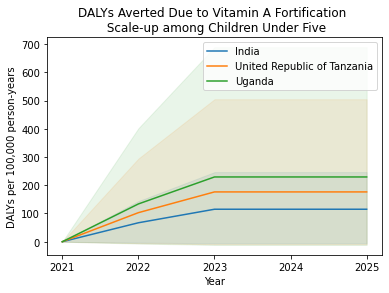

In [123]:
colors = ['tab:blue','tab:orange','tab:green']
locs = [163,189,190]
for i in list(range(len(locs))):
    rate = rates.loc[rates.location_id==locs[i]]

    plt.plot(rate.year + 1, rate['mean'],color=colors[i])
    plt.fill_between(rate.year + 1, rate['2.5%'], rate['97.5%'], color=colors[i], alpha=0.1)

plt.title('DALYs Averted Due to Vitamin A Fortification \n Scale-up among Children Under Five')
plt.xlabel('Year')
plt.ylabel('DALYs per 100,000 person-years')
plt.legend(['India','United Republic of Tanzania','Uganda'])
plt.xticks([2021,2022,2023,2024,2025])

([<matplotlib.axis.XTick at 0x2b0e1b936898>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

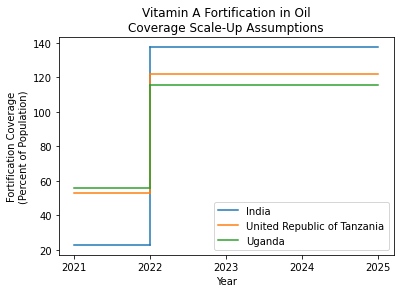

In [124]:
colors = ['tab:blue','tab:orange','tab:green']
locs = [163,189,190]
#for i in list(range(len(locs))):
i=0
alt = alternative_coverage.mean(axis=1).reset_index().rename(columns={0:'value'})
alt = alt.loc[alt.location_id==locs[i]]
plt.plot([2021,2022], [alt['value'].values[0] * 100,alt['value'].values[0] * 100], color=colors[i], label='India')
plt.plot([2022,2022], [alt['value'].values[0] * 100,alt['value'].values[1] * 100], color=colors[i])
plt.plot(alt.year[1:5] + 1, alt.value[1:5] * 100, color=colors[i])
i=1
alt = alternative_coverage.mean(axis=1).reset_index().rename(columns={0:'value'})
alt = alt.loc[alt.location_id==locs[i]]
plt.plot([2021,2022], [alt['value'].values[0] * 100,alt['value'].values[0] * 100], color=colors[i], label='United Republic of Tanzania')
plt.plot([2022,2022], [alt['value'].values[0] * 100,alt['value'].values[1] * 100], color=colors[i])
plt.plot(alt.year[1:5] + 1, alt.value[1:5] * 100, color=colors[i])
i=2
alt = alternative_coverage.mean(axis=1).reset_index().rename(columns={0:'value'})
alt = alt.loc[alt.location_id==locs[i]]
plt.plot([2021,2022], [alt['value'].values[0] * 100,alt['value'].values[0] * 100], color=colors[i], label='Uganda')
plt.plot([2022,2022], [alt['value'].values[0] * 100,alt['value'].values[1] * 100], color=colors[i])
plt.plot(alt.year[1:5] + 1, alt.value[1:5] * 100, color=colors[i])
    
plt.title('Vitamin A Fortification in Oil\nCoverage Scale-Up Assumptions')
plt.xlabel('Year')
plt.ylabel('Fortification Coverage\n(Percent of Population)')
plt.legend()#['India','United Republic of Tanzania','Uganda'])
plt.xticks([2021,2022,2023,2024,2025])